In [1]:
# %pip uninstall keras -y
# %pip install keras==3.6.0
# %pip list

In [2]:
%pip install keras==3.6.0
%pip install tensorflow
%pip install pandas
%pip install seaborn
%pip install scikit-learn
%pip install pretty_midi
%pip install music21
%pip install torch
%pip install torcheval


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import pretty_midi
import pathlib
import collections
import datetime
import glob
import music21
import tensorflow as tf
import torch
from torcheval.metrics.text import Perplexity
import random


# Music Gen using LSTM model

This project will use a 4 layer keras LSTM model to predict notes based on training from a famous jazz recording captures that were converted to midi.

The notebook has 3 main sections.
* Training Data Preparation
* Model Definition and fit
* Predictions based on sample input

### Helper Functions

Some conversion and database i/o functions were split into a separate python file to help readability of this notebook.  This are loaded here.

In [4]:
import importlib  # allows reload of my_functions
import my_functions

In [5]:
importlib.reload(my_functions)

<module 'my_functions' from '/Users/teovargo/SubmissionFolder/my_functions.py'>

### This cell defines global constants that are used throughout the notebook 

In [6]:
# Global things used throughout the notebook

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# length of trainig sequences
seq_length = 20

# Size of pitch vocab
vocab_size = 128

# Keys that will get extracted into the training set. This are the inputs to the model!
key_order = ['interval', 'step', 'duration', 'tempo', 'instrument_num', 'key_num']

# Songs to exclude from training
#skip_list = random.sample(range(1, 456), 16)
skip_list = [ 311, 50, 66, 283, 95, 303, 284, 238, 297, 276, 416, 254, 346, 161, 125, 362]

# Skipped songs to be used for Validation
val_list = skip_list[:10]

# Skipped songs to be used for Testing
test_list = skip_list[10:]


model_save_file = 'PureIntervalSave.keras'


### This cell will load training data using a SQL query and calculate some differential values

Training data is loaded into a Dataframe.  Many fields are just extracted from the wjazzd.db sqlite
database. Others are calculated on the dataframe once it is created.

Fields for each note from the database are created joining the tables "melody" and "solo_info"
* pitch - from melody.pitch midi note value (0-127)
* pitch_norm - from melody.pitch / 128 as pitch_norm  Normalized pitch.  (not used)
* start - from melody.onset as start  Start time of the note
* end - from melody.onset + melody.duration as end  End time of the note
* duration - from melody.duration duration of the note in seconds
* instrument - from solo_info.instrument string representing of the instrument used ie "cl" (clarinet)
* key - solo_info.key string value reprensenting the musical key ie: "Bb-maj"
* style - from solo_info.style string representing the song genre ie: "COOL" or "POSTBOP"
* tempo - from solo_info.avgtempo as tempo reprensented in BPM
* feel - from solo_info.rhythmfeel as feel string represening rhythmic feel ie "SWING" or "LATIN" 
* title - from solo_info.title,
* performer = from solo_info.performer string of the name of the artist on the solo

Once the data is loaded, these additional fields are create
* step - time between the previous note and this note
* interval - pitch difference between
* contour - interval abstraction based on my_functions.contour()



In [7]:
# This loads up all the notes in the dataset
pitchInst = my_functions.extract_training_data()

### Turn to alpha numeric lables into numbers for training input
* instrument_num maps to the type of instrument used in the solo
* key_num maps to the musical key that the tune was in (Bb-maj for example)

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
pitchInst['instrument_num'] = le.fit_transform(pitchInst['instrument']).astype(float)
pitchInst['key_num'] = le.fit_transform(pitchInst['key']).astype(float)


### Trim off extraneous notes from the training data and skip songs

For the model to train correctly, the training set must be an integral multiple of seq_length.


In [9]:
n_notes, train_notes = my_functions.trim_data_sequence(
        pitchInst, 
        skip_list, 
        seq_length,
        key_order)

# shift intervals to be all positive
train_notes[:,0] = train_notes[:,0] + 24

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

/Users/teovargo/SubmissionFolder/my_functions.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_subset = pd.concat([train_subset, dfs[i]], ignore_index=True)  # append to the set


TensorSpec(shape=(6,), dtype=tf.float64, name=None)

In [10]:
val_length, val_notes = my_functions.select_data_sequences(pitchInst, 
        val_list, 
        seq_length,
        key_order)

# shift intervals to be all positive
val_notes[:,0] = val_notes[:,0] + 24

val_notes_ds = tf.data.Dataset.from_tensor_slices(val_notes)
val_notes_ds.element_spec

/Users/teovargo/SubmissionFolder/my_functions.py:254: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_subset = pd.concat([train_subset, dfs[i]], ignore_index=True)  # append to the set


TensorSpec(shape=(6,), dtype=tf.float64, name=None)

In [11]:
val_seq_ds = my_functions.create_sequences(val_notes_ds, key_order, seq_length, vocab_size)
val_seq_ds.__len__

<bound method DatasetV2.__len__ of <_ParallelMapDataset element_spec=(TensorSpec(shape=(20, 6), dtype=tf.float64, name=None), {'interval': TensorSpec(shape=(), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(), dtype=tf.float64, name=None), 'tempo': TensorSpec(shape=(), dtype=tf.float64, name=None), 'instrument_num': TensorSpec(shape=(), dtype=tf.float64, name=None), 'key_num': TensorSpec(shape=(), dtype=tf.float64, name=None)})>>

In [12]:
batch_size = 64
buffer_size = val_length #  - seq_length  # the number of items in the dataset
val_ds = (val_seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [13]:
seq_ds = my_functions.create_sequences(notes_ds, key_order, seq_length, vocab_size)
seq_ds.__len__

<bound method DatasetV2.__len__ of <_ParallelMapDataset element_spec=(TensorSpec(shape=(20, 6), dtype=tf.float64, name=None), {'interval': TensorSpec(shape=(), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(), dtype=tf.float64, name=None), 'tempo': TensorSpec(shape=(), dtype=tf.float64, name=None), 'instrument_num': TensorSpec(shape=(), dtype=tf.float64, name=None), 'key_num': TensorSpec(shape=(), dtype=tf.float64, name=None)})>>

In [14]:
batch_size = 64
buffer_size = n_notes #  - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

### Build the model

If the model can be restored from the saved file, use that.  Otherwise, build and train the model

In [15]:
%%time

try:
  model = tf.keras.models.load_model(model_save_file)
except:
  # definition for the inputs.  Note how num of inputs is realted to size of key_order global
  input_shape = (seq_length, len(key_order))
  learning_rate = 0.010

  #input layer
  inputs = tf.keras.Input(input_shape)
  #hidden layers
  x = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
  x = tf.keras.layers.Dropout(0.20, seed=seed)(x) #dropout layer
  x = tf.keras.layers.LSTM(16, return_sequences=True)(x)
  x = tf.keras.layers.Dropout(0.20, seed=seed)(x) #dropout layer
  x = tf.keras.layers.LSTM(16, return_sequences=False)(x) #last layer to outputs




  outputs = {
    'interval': tf.keras.layers.Dense(128, name='interval')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
  }

  model = tf.keras.Model(inputs, outputs)

  loss = {
        'interval':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        'step': "mean_squared_error",
        'duration': "mean_squared_error",
  }

  # loss = {
  #       'pitch':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  #       'step': mse_with_positive_pressure,
  #       'duration': mse_with_positive_pressure,
  # }

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss=loss, optimizer=optimizer)

  model.summary()
  # these are the three outputs of the model

  model.compile(
      loss=loss,
      loss_weights={
          'interval': 1.0,
          'step': 1.0,
          'duration':1.0,
      },
      optimizer=optimizer,
  )

  model.evaluate(train_ds, return_dict=True)
  callbacks = [
      tf.keras.callbacks.ModelCheckpoint(
          filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
          save_weights_only=True),
      tf.keras.callbacks.EarlyStopping(
          monitor='loss',
          min_delta=0.001,
          patience=5,
          verbose=1,
          start_from_epoch=2,
          restore_best_weights=True),
  ]
  
  epochs = 30

  history = model.fit(
      train_ds,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=val_ds,
  )
  model.save(model_save_file)
  np.save('history_interval.npy', history.history, allow_pickle=True) # save training data for later

CPU times: user 101 ms, sys: 28.6 ms, total: 129 ms
Wall time: 344 ms


In [16]:
loaded_history = np.load('history_interval.npy', allow_pickle=True) # save training data for later
loaded_history.item(0)['loss']

[2.7269580364227295,
 2.7101428508758545,
 2.7079358100891113,
 2.706768274307251,
 2.706087350845337,
 2.7056212425231934,
 2.7052905559539795,
 2.705057382583618,
 2.704881429672241,
 2.7047433853149414,
 2.704636812210083]

In [17]:
def predict_next_note(
    notes: np.ndarray,
    init_pitch: float,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  interval_logits = predictions['interval']
  step = predictions['step']
  duration = predictions['duration']

  interval_logits /= temperature 
  interval = tf.random.categorical(interval_logits, num_samples=1) 
  interval = tf.squeeze(interval, axis=-1) 
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)
  interval = interval -24
  pitch = init_pitch + interval


  # `step` and `duration` values should be non-negative

  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)
  

  return int(pitch), int(interval), float(step), float(duration), interval_logits

In [18]:
def calc_unit_perplexity(logits, target): 
  metric=Perplexity()
  input = torch.tensor(logits)
  target_tens = torch.tensor([target])
  metric.update(input, target_tens)
  return metric.compute()


#calc_unit_perplexity(agg_logits[0],)

In [19]:
temperature = 1.0
num_predictions = seq_length

def note_loop(song):
  test_notes = pitchInst[pitchInst['melid'] == song].reset_index()
  sample_notes = np.stack([test_notes[key] for key in key_order], axis=1)

  input_notes = sample_notes[:seq_length]

  # These are common fields to the entire test set
  tempo = test_notes['tempo'].iloc[seq_length]
  inst = test_notes['instrument_num'].iloc[seq_length]
  key = test_notes['key_num'].iloc[seq_length]
  title = test_notes['title'].iloc[seq_length]
  performer = test_notes['performer'].iloc[seq_length]
  instrument_name = test_notes['instrument'].iloc[seq_length]
  # intitial pitch from where to apply the predicted intervals
  pitch = test_notes['pitch'].iloc[seq_length]


  generated_notes = []
  # this is the last start time of the prompt set
  prev_start = test_notes['start'][seq_length]
  agg_logits = []
  pplex = []
  #contour = 0  #initial contour should be last contour of input sequence
  for i in range(num_predictions):
    pitch, interval, step, duration, interval_logits = predict_next_note(input_notes, pitch, model, temperature)
    start = prev_start
    end = start + duration
    agg_logits.append(interval_logits)
    target_note = test_notes['interval'].iloc[seq_length + i].astype(int)
    pplex.append(calc_unit_perplexity([interval_logits], [target_note]))
    # TODO:
    # This line has to change when you change the inputs to the model.  The input_note
    # that is getting appended to input notes needs to have the correct number and order of 
    # fields cause it is gonna get fed back into the model.predict function
    # input_note = (pitch, step, duration)
    input_note = (interval, step, duration, tempo, inst, key)
    generated_notes.append((*input_note, pitch, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes , np.expand_dims(input_note, 0), axis=0) 
    prev_start = start + step
    
  generated_notes = pd.DataFrame(
      generated_notes, columns=(*key_order, 'pitch', 'start', 'end'))

  start_df = test_notes[:seq_length].drop(['interval'], axis=1)
  

  # string together the first training data and the generated notes
  full_sequence = pd.concat([start_df, generated_notes], ignore_index=True)

  example_file = f"PureInterval-Song-{song}_seq-{seq_length}-{performer}-{title}.midi"  # adds a prefix to the sample filename
  my_functions.notes_to_midi(full_sequence[['pitch', 'step', 'duration', 'tempo']], out_file=example_file, instrument_name='Acoustic Grand Piano')

  return test_notes[:len(full_sequence)], full_sequence, generated_notes, title, performer, agg_logits, pplex


In [20]:
run_list = test_list
#run_list = [41, 42, 74, 75, 89]
targets, full_sequence, generated_notes, title, performer, agg_logits, pplex = note_loop(run_list[1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/var/folders/0n/vghykfw130n6133zv_3yq7_c0000gn/T/ipykernel_5137/3803190799.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  input = torch.tensor(logits)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


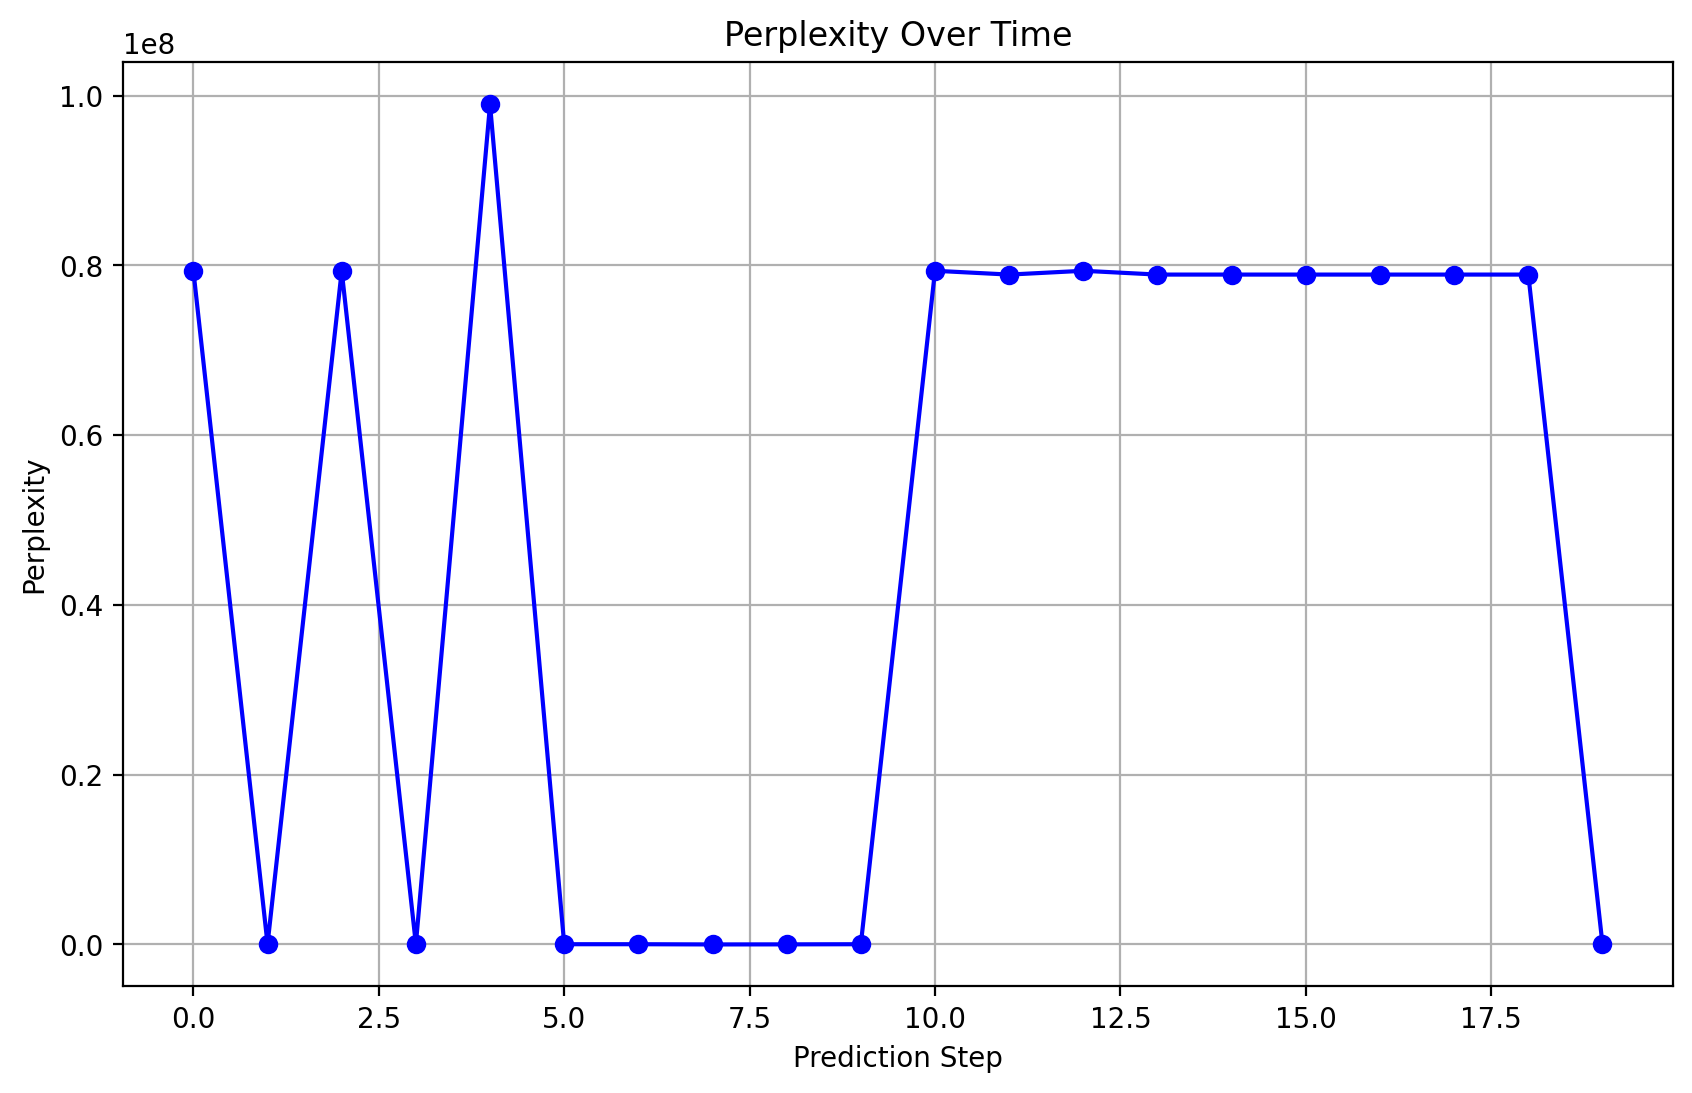

In [21]:
import matplotlib.pyplot as plt

# Plot pplex as a line graph
plt.figure(figsize=(10, 6))
plt.plot(pplex, marker='o', linestyle='-', color='b')
plt.title('Perplexity Over Time')
plt.xlabel('Prediction Step')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

In [22]:
def calc_perplexity(agg_logits, target, num_predictions):
  x = target['pitch'].tail(num_predictions).astype(int).to_numpy()
  np.array_split(x, num_predictions)
  metric=Perplexity()
  input = torch.tensor(agg_logits)
  target_tens = torch.tensor(np.array_split(x, num_predictions))
  metric.update(input, target_tens)
  return metric.compute()

In [23]:
calc_perplexity(agg_logits, targets, num_predictions)

tensor(87162833.2845, dtype=torch.float64)

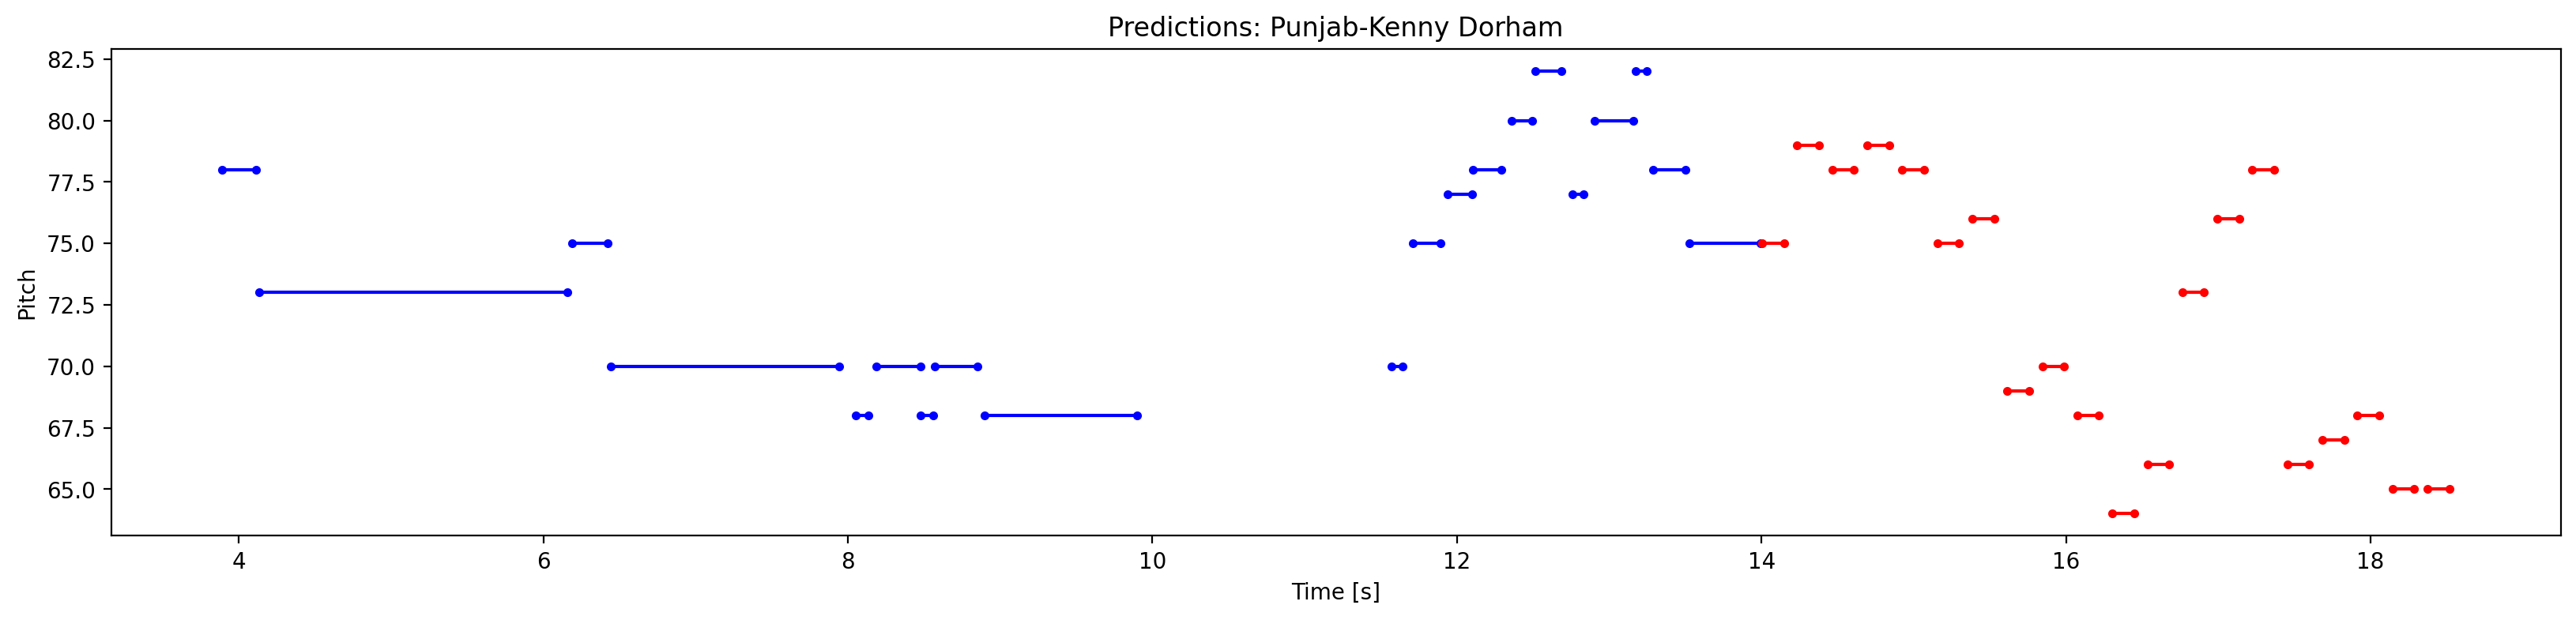

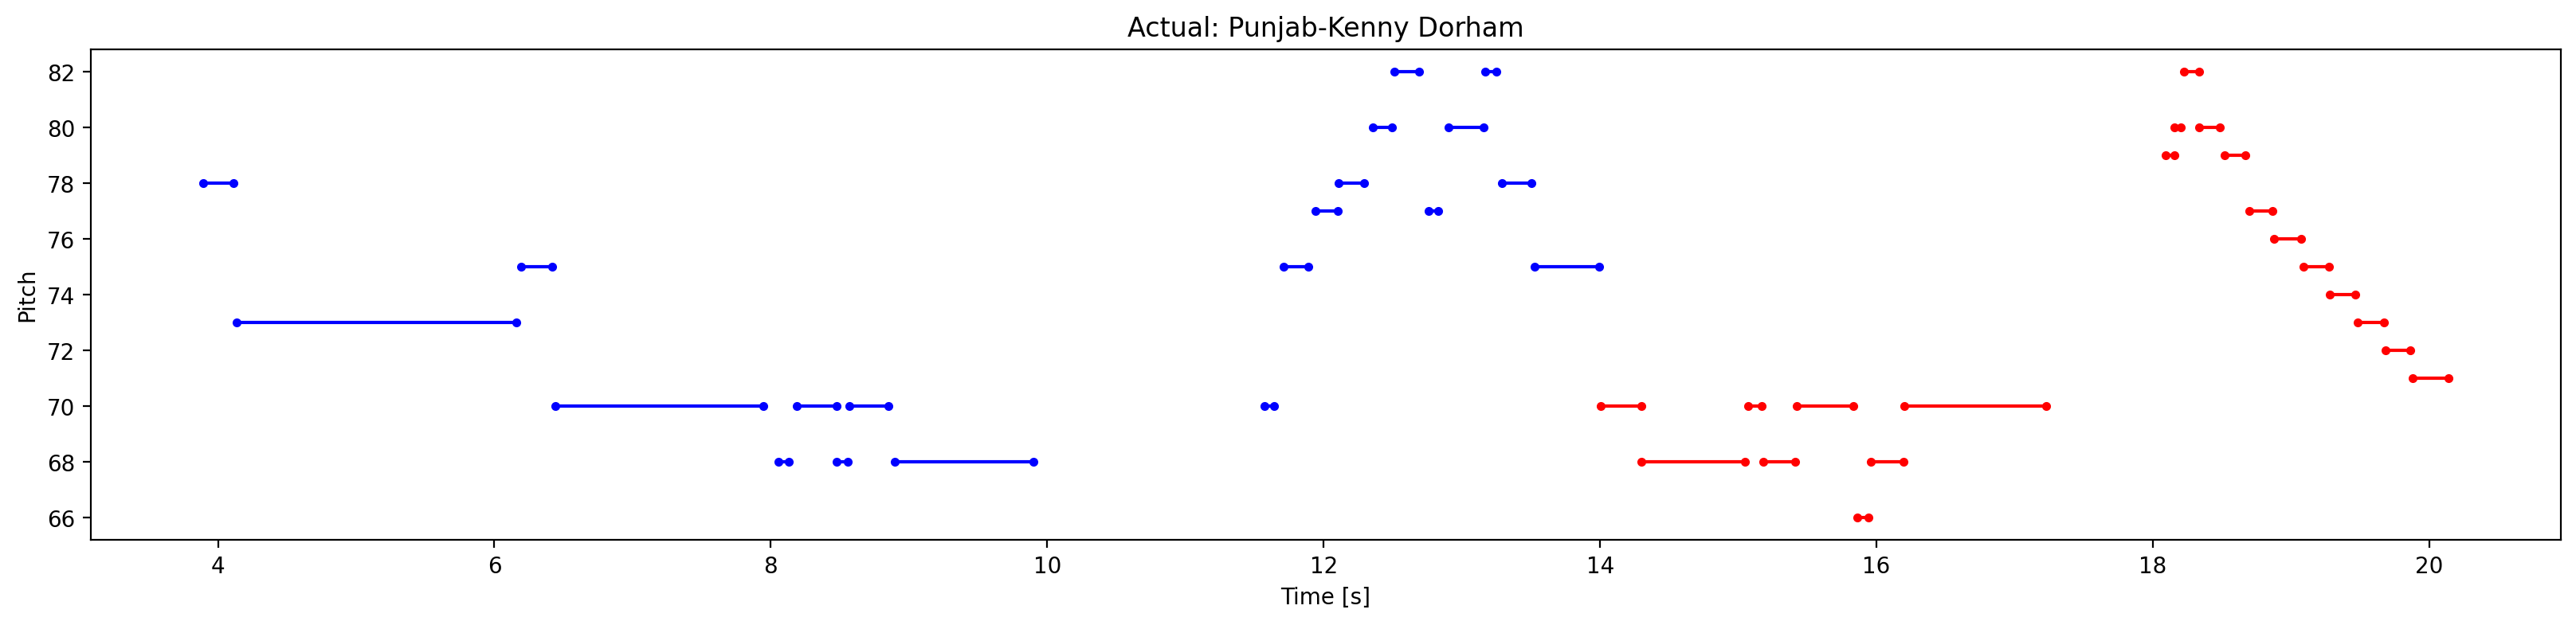

In [24]:
my_functions.plot_notes(full_sequence, seq_length ,heading=f'Predictions: {title}-{performer}')
my_functions.plot_notes(targets, seq_length, heading=f'Actual: {title}-{performer}')

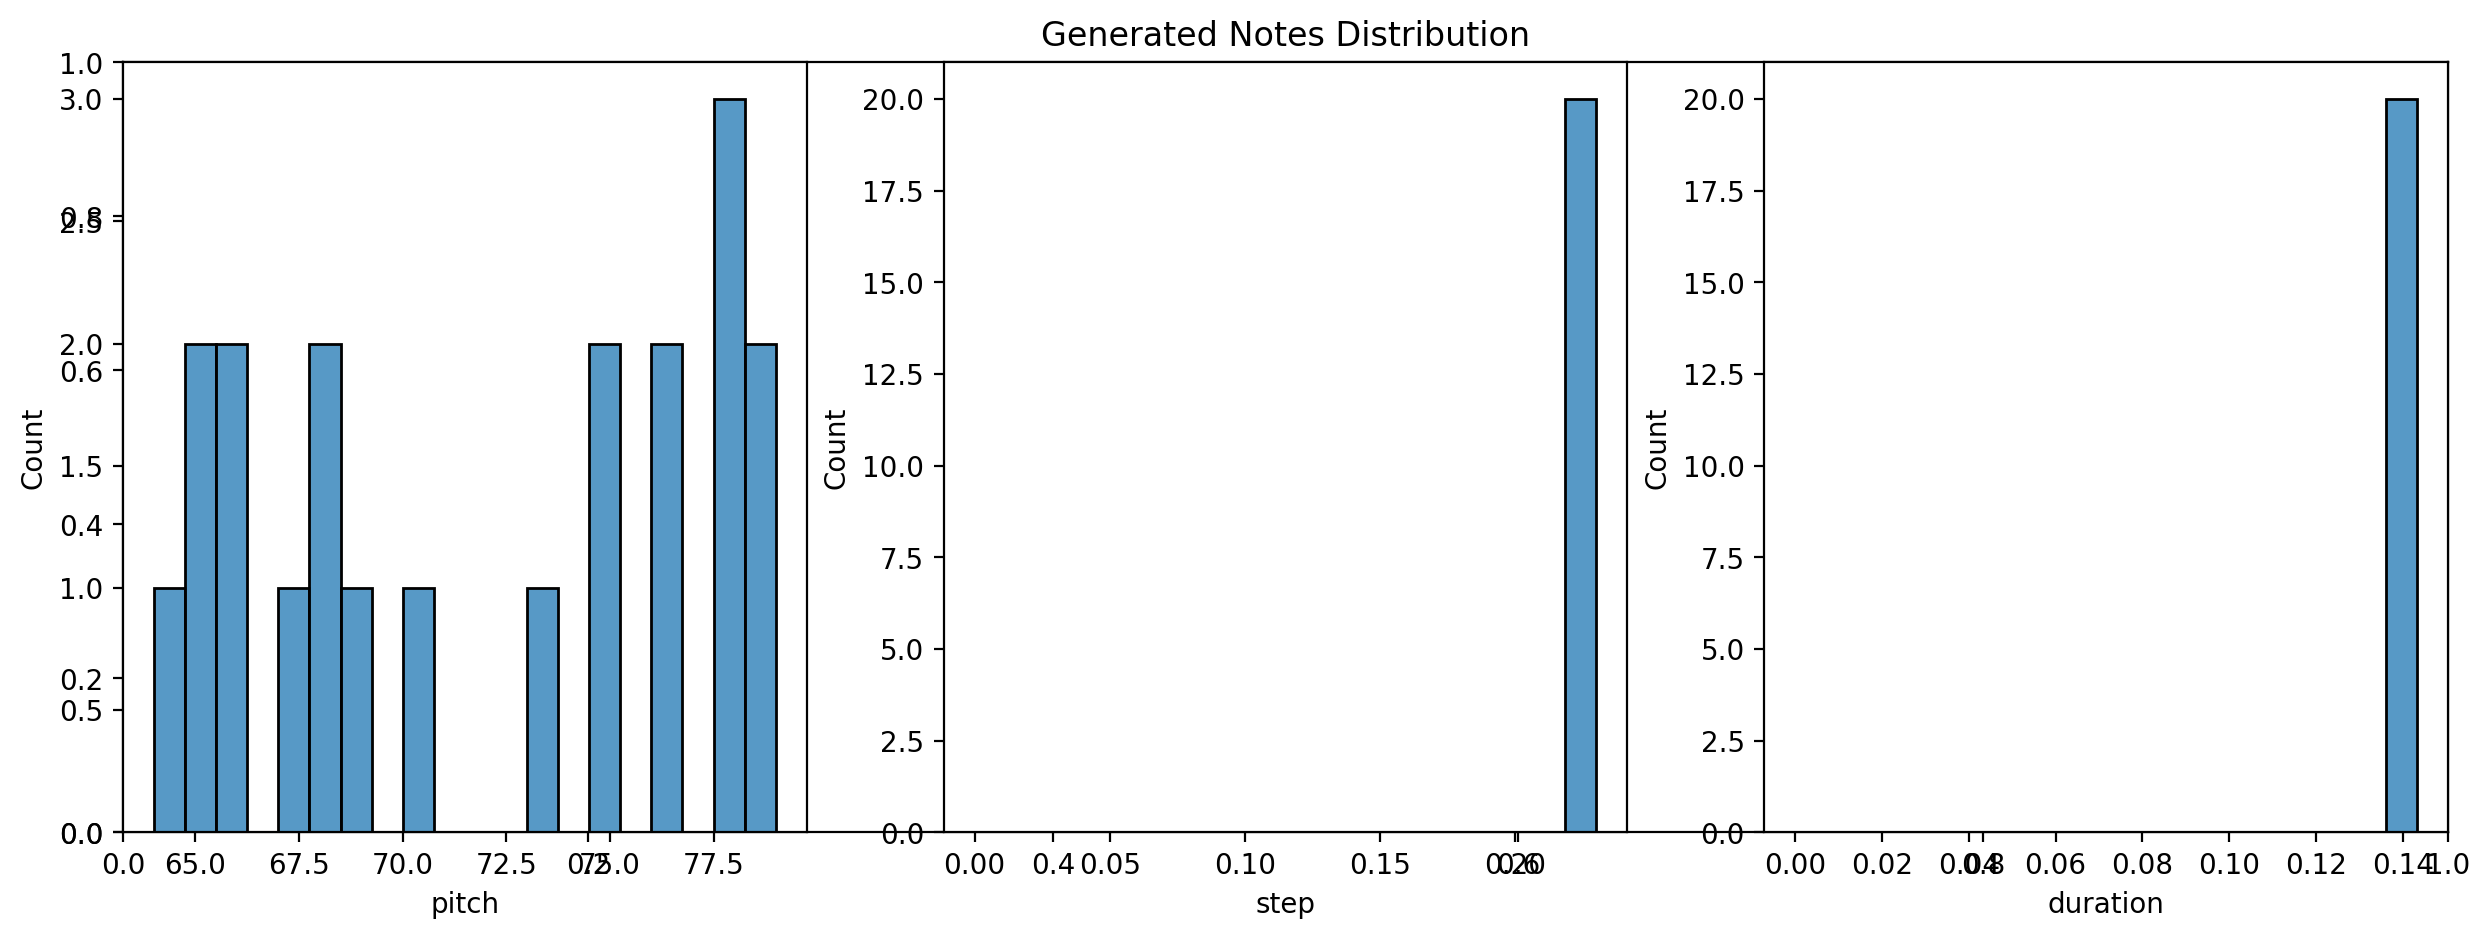

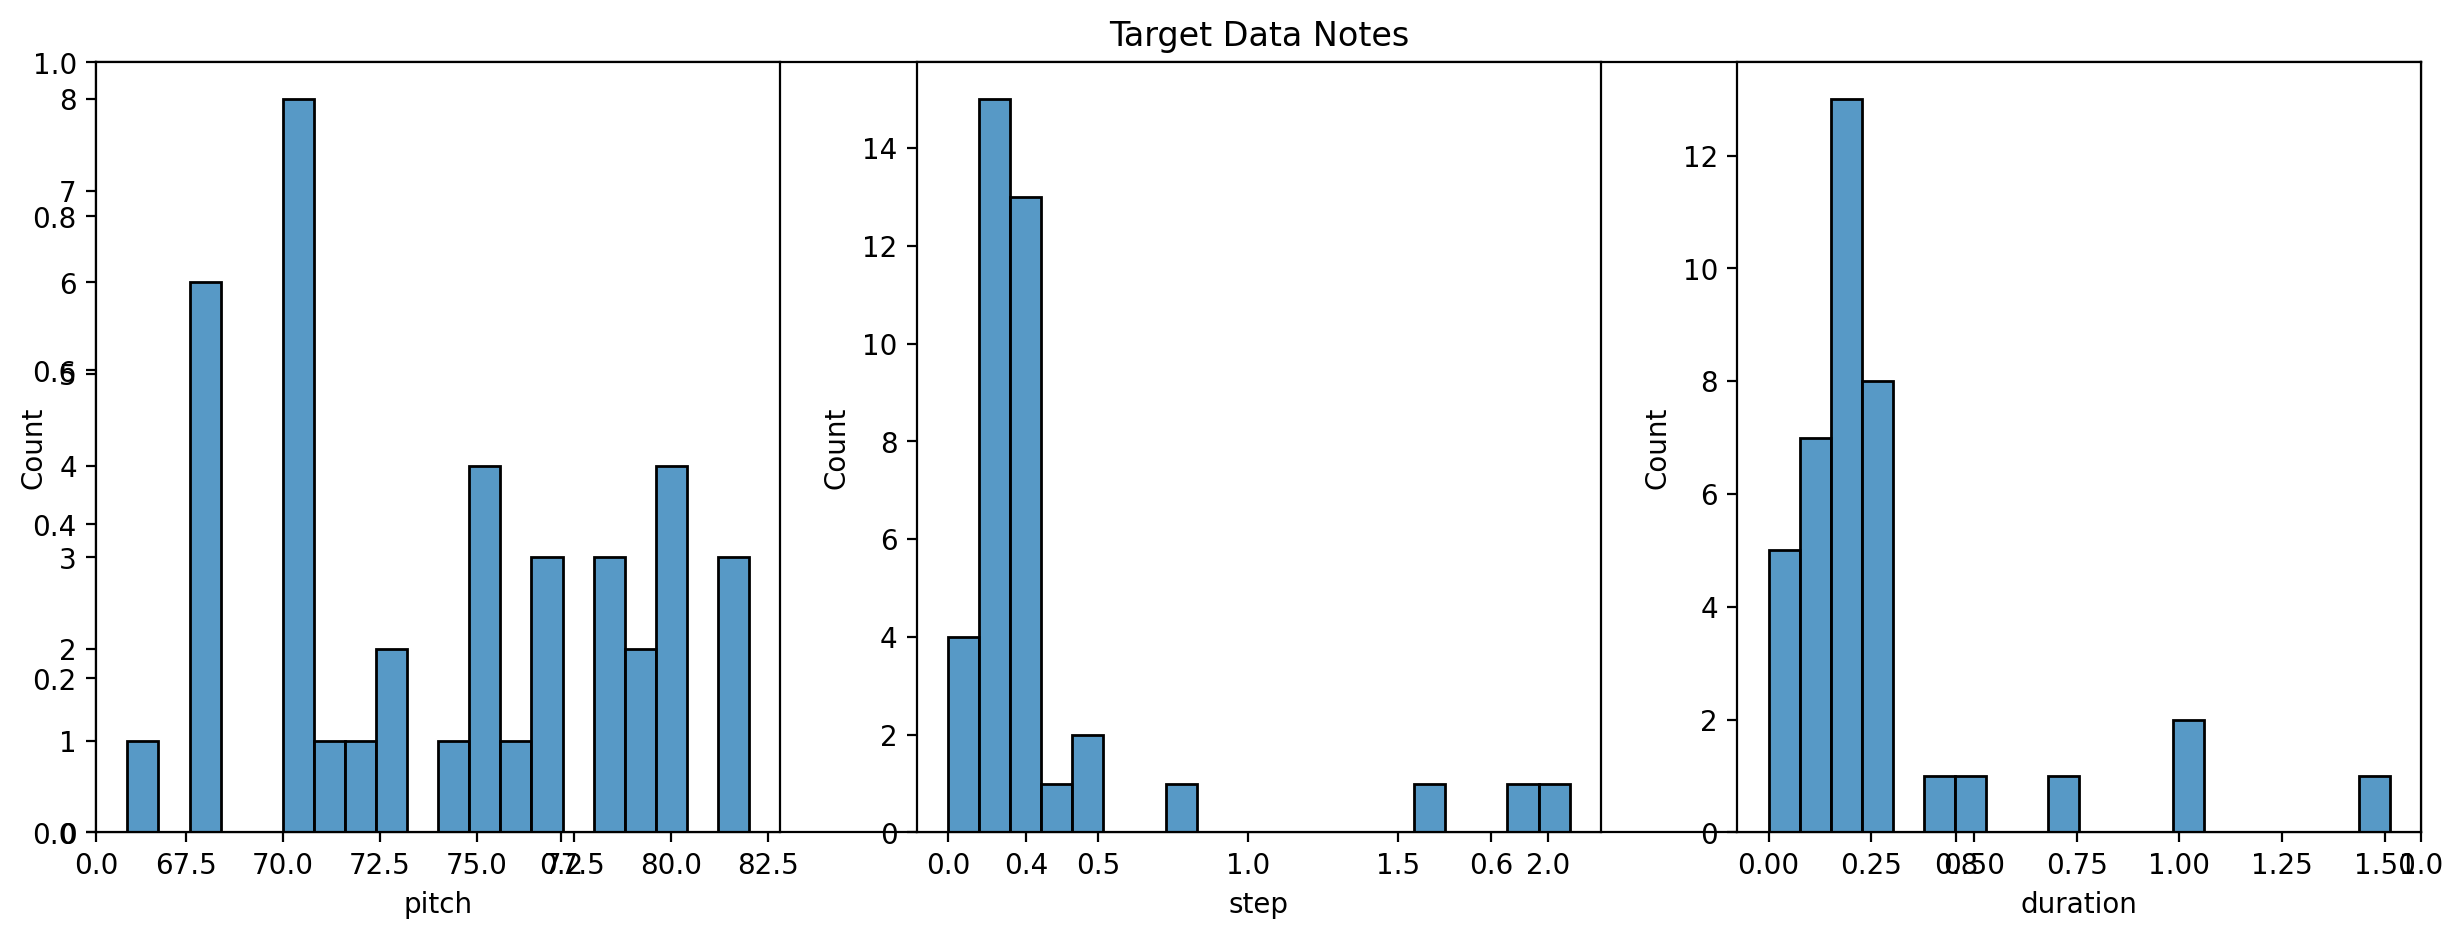

In [25]:
my_functions.plot_distributions(generated_notes, title="Generated Notes Distribution")
my_functions.plot_distributions(targets, title="Target Data Notes")